In [1]:
%matplotlib inline

# from TL import preproc_TL 
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch 
import numpy as np
import math 
import gc
import time 
import sys 
from util import * 



from time import sleep
import numpy as np
import scipy
import warnings
import pylops
warnings.filterwarnings("ignore")


from scipy.sparse.linalg import lsqr
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.optimization.leastsquares import *
from pylops.utils.wavelets import ricker
from pylops.utils.signalprocessing import *


In [2]:
# data paths and parameters
data_path = '../LSTM_SEAM_submitted_v2/data/'
base_path = f"{data_path}/base_seam.npy" 
mon_path = f"{data_path}/mon_seam.npy" 
# Mclean_path = f"{data_path}/mon_seam_c.npy"

parm = {
 'nt': 2500,
 'ng': 501,
 'ns': 60,
 'dt':  0.0024,
 'dg': 0.02500000037252903,
 'ds': 0.17499999701976776,
 'ot': 0.0,
 'og': 0.0,
 'os': 1.0}
 
dt = parm['dt']

# define the window for plotting  
# start = 100
# last =  900 

# # define the overburden window 
start = 550
last =  850 

feature_leangth = 21

start2 = 550
last2 =  1600 

mxoffset = 5 # km 



In [3]:
# 
base = np.load(base_path)
mon = np.load(mon_path)
ns,ng,nt = base.shape

base = muting(base,mxoffset,parm)
mon  = muting(mon,mxoffset,parm)


# convert to 2D 
base = base.reshape((ns*ng,nt))
mon = mon.reshape((ns*ng,nt))

# design window 
base_win = base[:,start:last]
mon_win = mon[:,start:last]   





In [4]:
# Design filter 



nh = 41 # size of matching filter
wavc = 20 # center of matching filter

# Estimate matching filter from base to mon
Cop = VStack([MatrixMult(convmtx(base_win[iy], nh)[wavc:-nh+wavc+1]) for iy in range(base_win.shape[0])])
hmatch = Cop / mon_win.ravel()

# Apply the matching filter to base to get mon
mon_win_pred = (Cop @ hmatch).reshape(mon_win.shape)


## Apply on the reservoir part 


In [5]:


# define the reservoir from the trace 

base_win2 = base[:,start2:last2]
mon_win2 = mon[:,start2:last2]   

# Estimate matching filter from base to mon
Cop = VStack([MatrixMult(convmtx(base_win2[iy], nh)[wavc:-nh+wavc+1]) for iy in range(base_win2.shape[0])])


# Apply the matching filter to base to get mon
mon_win_pred2 = (Cop @ hmatch).reshape(mon_win2.shape)



  

In [18]:
#Convert back to 3D 

B=base_win2.reshape((ns,ng,last2-start2))
M=mon_win2.reshape((ns,ng,last2-start2))
Pr = mon_win_pred2.reshape((ns,ng,last2-start2))


# Take few shots as in the inference notebook 
# B = B[20:41:4,]
# M = M[20:41:4,]
# Pr = Pr[20:41:4,]




In [14]:
# Metrics 

def RMS(a):
    N = a.shape[0]
    return np.sqrt(1/N * np.sum(a**2))
#     return np.sqrt(np.mean(a**2))

def NRMS (B,M,ti,tf):
    N = B.shape[0]
    b = B[:,ti:tf].copy()
    m = M[:,ti:tf].copy()
    num = RMS(b-m)
    den = RMS(b)+RMS(m)
    score = 200 * num/den
    return score
    
def phi(b,m):
    num = np.sum(b*m)
    den = np.sqrt(np.sum(b**2)*np.sum(m**2))
    return num/den
    
def predictability(B,M,ti,tf):
    N = B.shape[0]
    b = B[:,ti:tf].copy()
    m = M[:,ti:tf].copy()
    w = b.shape[-1]
    tao = 0
    num = 0 
    den = 0
    for tao in range(w//2): 
        phi_bm = phi(b[tao:tao+w//2],m[tao:tao+w//2])
        phi_bb = phi(b[tao:tao+w//2],b[tao:tao+w//2])
        phi_mm = phi(m[tao:tao+w//2],m[tao:tao+w//2])
        num   += phi_bm * phi_bm
        den   += phi_bb * phi_mm
    score = 100 * num/den
    return score


metric window is [1.1-1.9000000000000001]


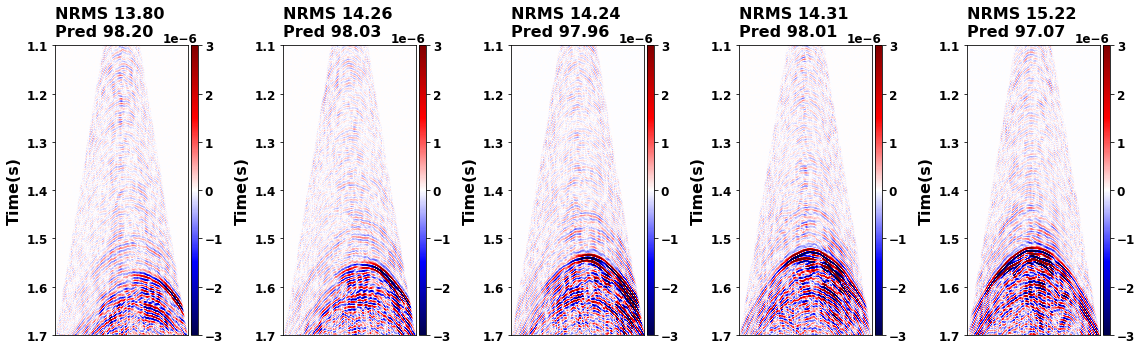

In [17]:
# ''' Shot differeces plots ''' 
# import matplotlib
# from mpl_toolkits.axes_grid1 import make_axes_locatable


# # Shot plotting 

# # matplotlib.rc('image', cmap='gray')    
# matplotlib.rc('image', cmap='seismic') 
# font = {
# 'weight' : 'bold',
# 'size'   : 12}
# matplotlib.rc('font', **font)
# matplotlib.rcParams.update({'font.size': 12})
# dt = 0.002
# vmax = 3e-6
# vmin = -vmax


# ncols=5
# #-----------------------------------------------------------


# def plot_differences(shot1,shot2,ncols,savedir,metric=True):

#     # Measure metric window
#     ti = 0
#     tf = 400
#     print(f"metric window is [{start*dt}-{(start+tf)*dt}]")
#     fig, ax = plt.subplots(1,ncols,figsize=(16,5))
#     for i in range (ncols):
#         if metric:
#             nrms = NRMS(shot1[i],shot2[i],ti,tf)
#             pred = predictability(shot1[i],shot2[i],ti,tf)
#         shot_diff = shot1[i] - shot2[i]
        
#         im = ax[i].imshow(shot_diff[~np.all(shot1[i]==0 , axis=1)].T ,
#             vmin=vmin,vmax=vmax,extent=[0,2000,last*dt,start*dt])
#         ax[i].axis("tight")
#         ax[i].set_ylabel("Time(s)",fontsize=16,fontweight='bold')
#         ax[i].axes.xaxis.set_visible(False)
#         if metric: 
#             ax[i].text(0.05,1.08,
#                 f"NRMS {nrms:.2f} \nPred {pred:.2f}",size=16)

#         divider = make_axes_locatable(ax[i])
#         cax = divider.append_axes('right', size='5%', pad=0.05)
#         fig.colorbar(im, cax=cax, orientation='vertical')
#     fig.tight_layout(pad=1.0)
#     fig.savefig(savedir, bbox_inches='tight')

  



# plot_differences(M,Pr,ncols=5,savedir='./Fig/MF_diff',metric=True)







In [20]:
pred_diff = M -Pr


path = './output_data/'
nt_resamble=7500
# ---------  pred difference 
pred_diff_all = np.zeros((ns,ng,nt))
pred_diff_all[:,:,start2:last2] = pred_diff 
# Resamble to 7500 
pred_diff_all= resize(pred_diff_all,(pred_diff_all.shape[0],pred_diff_all.shape[1],nt_resamble))    
filename = 'mf_diff.rsf@'
filename = path+filename
pred_diff_all.astype('float32').tofile(filename)
print("pred_diff shots is saved ")


pred_diff shots is saved 


In [21]:
pred_diff_all.shape

(60, 501, 7500)